In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.interpolate import interp1d

Welcome to ROOTaaS 6.06/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/'

In [3]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight','omega'
           ,'Plead_P','Plead_theta','Plead_phi','Precoil_P','Precoil_theta','Precoil_phi'
           ,'electron_phi','electron_theta','Emiss'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss1000_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )

In [4]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials","NoPrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')

    for direction in ['x','y']:
        cm_pars['sigma_'+direction+'_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_'+direction+'_unweighted']) - np.square(0.02))
        cm_pars['sigma_'+direction+'_before_acc_corr_err'] = cm_pars['sigma_'+direction+'Err_unweighted']

    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
    
cm_pars = cm_parameters['PrecFiducials']

# $p_{recoil}$

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/ResposeToReviewers/Precoil_P_theta.pdf


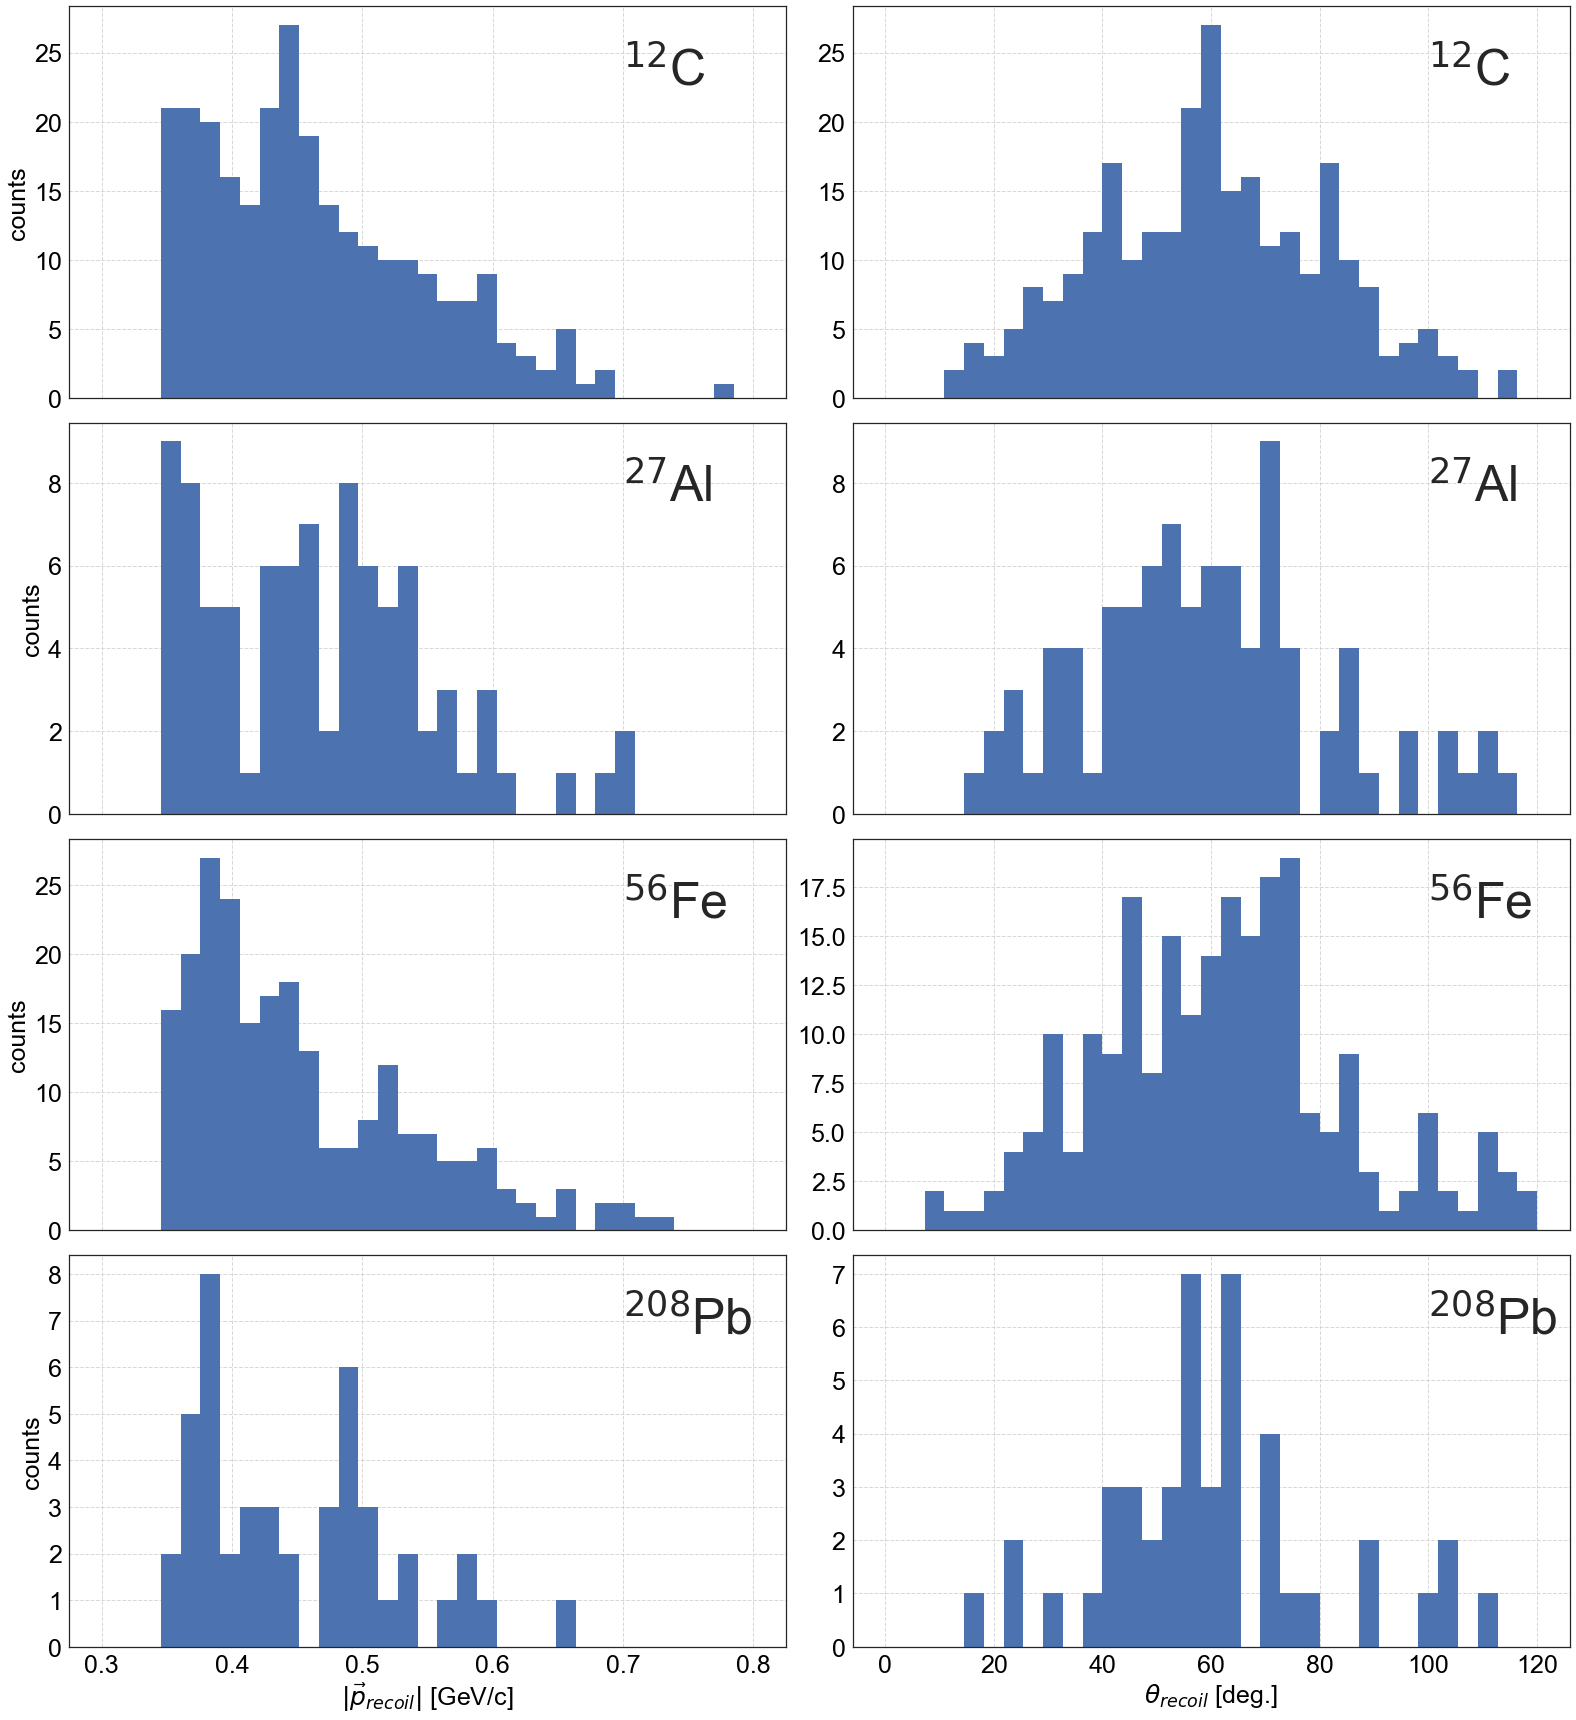

In [19]:
bins=np.linspace(0.3,0.8,45)

fig=plt.figure(figsize=(22,24))
for itarget,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):

    ax=fig.add_subplot( 4 , 2 , 2*itarget+1 )
    plt.hist( data300Pmiss600_PrecFid[target]['Precoil_P'] , bins=np.linspace(0.3,0.8,34))
    set_axes(ax,r'$|\vec{p}_{recoil}|$ [GeV/c]' if itarget==3 else '','counts',do_add_grid=True)
    plt.text(0.7,0.8*np.max(ax.get_ylim()),name,fontsize=50)
    if itarget<3: ax.get_xaxis().set_major_formatter(NullFormatter())
        
    ax=fig.add_subplot( 4 , 2 , 2*itarget+2 )
    plt.hist( 180./np.pi*data300Pmiss600_PrecFid[target]['Precoil_theta'] , bins=np.linspace(0,120,34))
    set_axes(ax,r'$\theta_{recoil}$ [deg.]' if itarget==3 else '',do_add_grid=True)
    plt.text(100,0.8*np.max(ax.get_ylim()),name,fontsize=50)
    if itarget<3: ax.get_xaxis().set_major_formatter(NullFormatter())


plt.tight_layout()
filename = figures_path + 'ResposeToReviewers/Precoil_P_theta.pdf'
plt.savefig(filename)
print 'saved',filename

## fit with RooPlot

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionC12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionAl27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionFe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistributionPb208.pdf


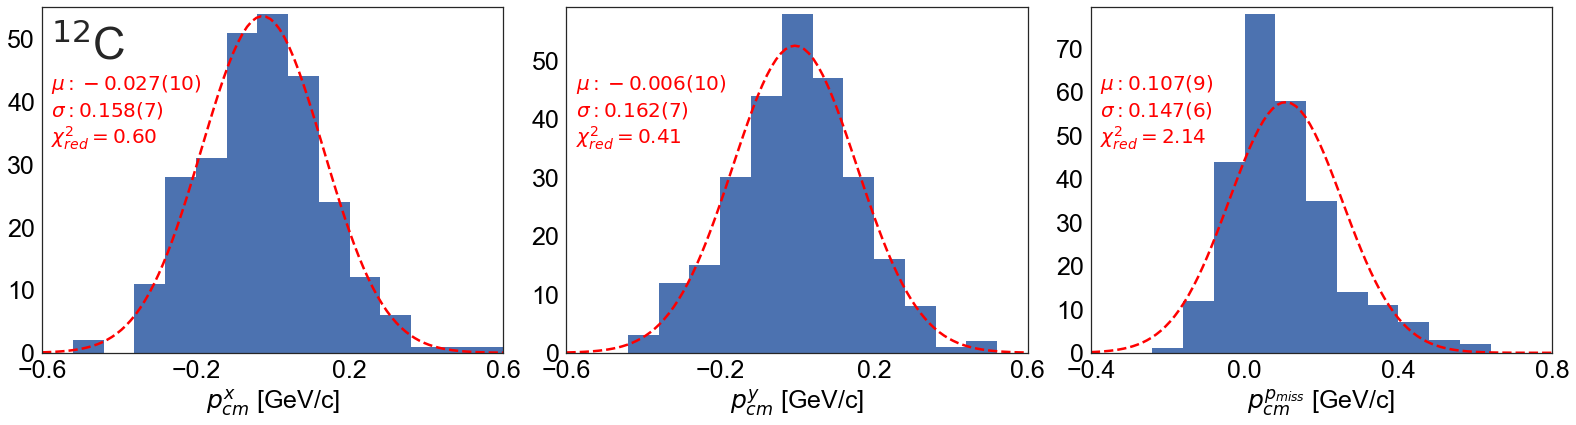

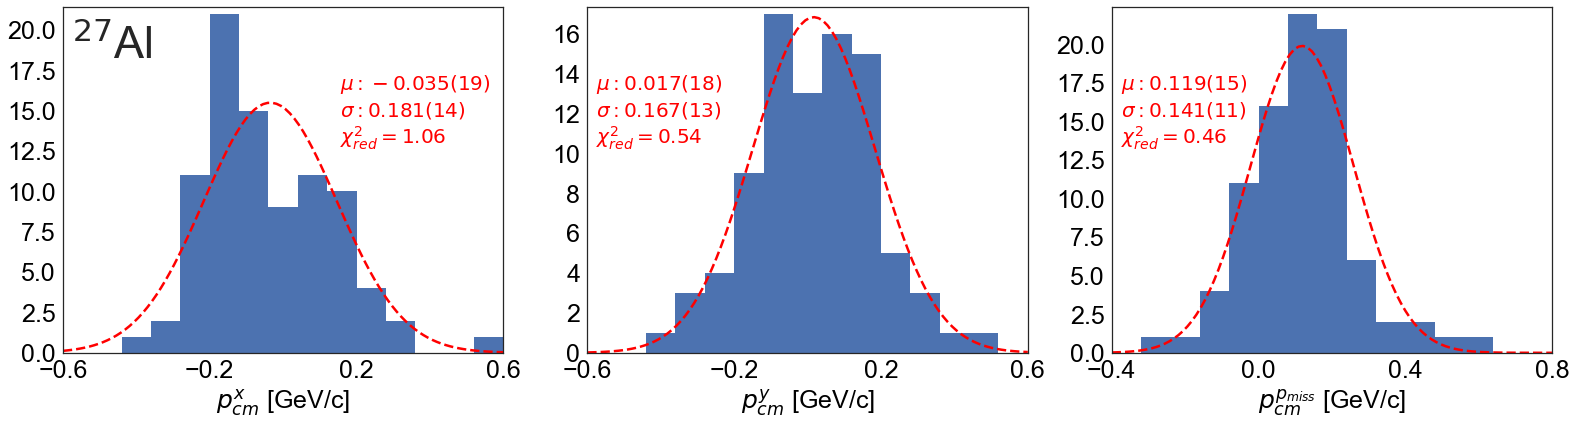

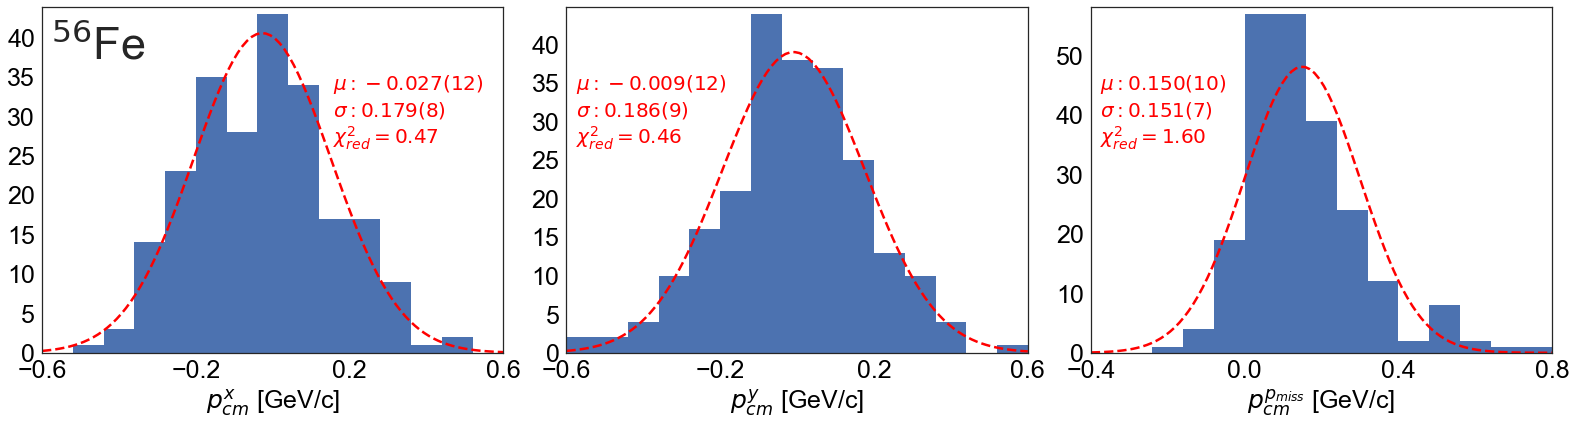

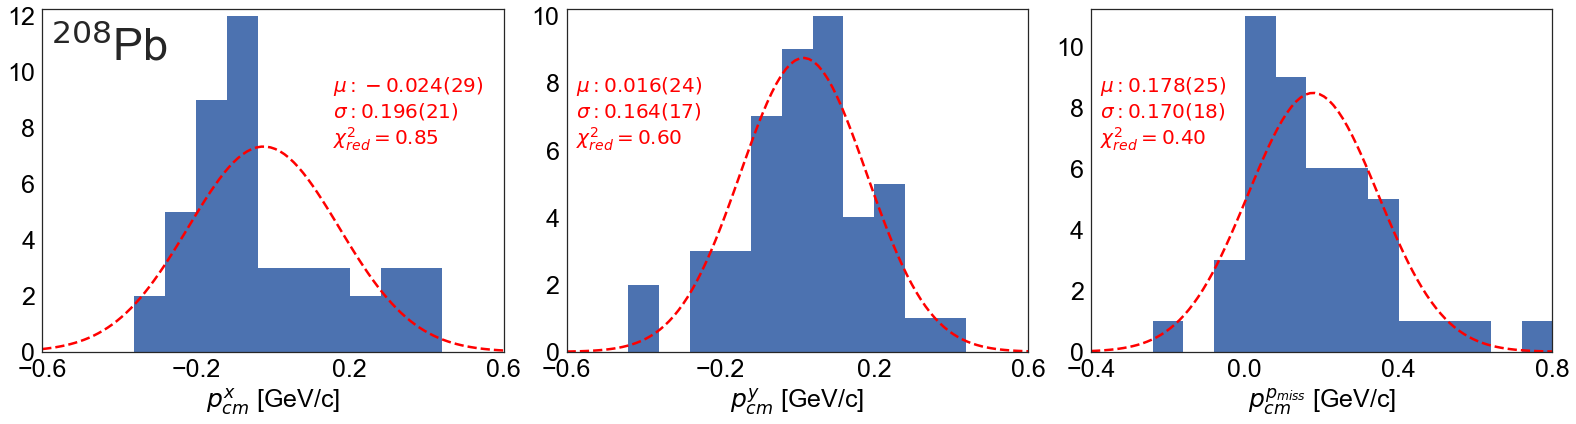

In [5]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data300Pmiss600_PrecFid[target]['pcm'+direction]
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,16)

        h,bins,_=plt.hist( x,  bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        cm_pars_target = cm_pars[cm_pars['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])

        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label
                 , xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

        
    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/MeasuredDistribution'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

## momentum vectors of the final-state protons

In [6]:
theta_line = np.linspace(20,120,50)

In [7]:
mom = 0.3

def fa(p):
    return p[0] + p[1]*np.exp(p[2]*(mom-p[3]))
def fb(p):
    return p[0] + p[1]*mom*np.exp(p[2]*np.square(mom-p[3]))
def ftheta_min(p):
    return p[0] + p[1]/np.square(mom) + p[2]*mom + p[3]/mom + p[4]*np.exp(p[5]*mom)

def phi_limits(sector , DeltaPhi_min, DeltaPhi_max):
    return (60.*sector - DeltaPhi_min) , (60.*sector + DeltaPhi_max)
def Delta_phi(a,theta_min,b):
    return (a * (1 - 1./( ((theta_line - theta_min)/b) + 1 ) ))

In [8]:
# sectors:
phi_min_array,phi_max_array=[],[]

# sector 1
DeltaPhi_min=Delta_phi( fa([25,-12,1.644,4.4]),ftheta_min([7,0.207,0.169,0.1,0.1,-0.1]),fb([4,2,-0.978,0.5]))
DeltaPhi_max=Delta_phi(fa([25,-11.9735,0.803,4.4]),ftheta_min([7,0.207,0.169,0.1,0.1,-0.1]),fb([2.53,0.442,-2,1.02]))
phi_min_max = phi_limits(sector=1 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 2
DeltaPhi_min=Delta_phi( fa([25.,-12.,1.519,4.4]),ftheta_min([5.5,0.1,0.506,0.1,3.307,-0.652]),fb([4.,2.,-2.,0.5]))
DeltaPhi_max=Delta_phi(fa([24.81,-8.,0.85,4.8]),ftheta_min([5.5,0.1,0.506,0.1,3.307,-0.652]),fb([2.65,0.201,-0.179,1.6]))
phi_min_max = phi_limits(sector=2 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 3
DeltaPhi_min=Delta_phi( fa([25.,-12.,1.1095,4.4]),ftheta_min([7.06,0.127,-0.066,0.100,4.499,-3.17]),fb([2.784,2,-1.73,0.5]))
DeltaPhi_max=Delta_phi(fa([24.87,-8.,1.0125,4.8]),ftheta_min([7.06,0.127,-0.066,0.100,4.499,-3.17]),fb([3.17,1.275,-2,0.5]))
phi_min_max = phi_limits(sector=3 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 4
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.9778,4.4]),ftheta_min([6.32,0.1,0.2217,0.1,5.31,-3.3]),fb([3.58,1.38,-2,0.5]))
DeltaPhi_max=Delta_phi(fa([25,-12,0.911,4.4]),ftheta_min([6.32,0.1,0.2217,0.1,5.31,-3.3]),fb([2.47,1.76,-1.894,1.04]))
phi_min_max = phi_limits(sector=4 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 5
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.955366,4.4]),ftheta_min([5.5,0.211,0.6409,0.1,3.2,-1.108]),fb([3.32277,0.041,-0.954,0.5]))
DeltaPhi_max=Delta_phi(fa([25.,-8.526,0.683,4.8]),ftheta_min([5.5,0.211,0.6409,0.1,3.2,-1.108]),fb([2.424,1.254,-2,0.8157]))
phi_min_max = phi_limits(sector=5 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

# sector 6
DeltaPhi_min=Delta_phi( fa([25.,-12.,0.969,4.4]),ftheta_min([5.5,0.2816,0.358,0.1,0.776,-0.46]),fb([4,2,-2,1.086]))
DeltaPhi_max=Delta_phi(fa([25,-8,0.888,4.8]),ftheta_min([5.5,0.2816,0.358,0.1,0.776,-0.46]),fb([2.64,0.159,-2,1.31]))
phi_min_max = phi_limits(sector=0 , DeltaPhi_min=DeltaPhi_min, DeltaPhi_max=DeltaPhi_max)
phi_min_array.append(phi_min_max[0])
phi_max_array.append(phi_min_max[1])

phi_sector = [0.5*(phi_max_array[0]+phi_min_array[1])
                      ,0.5*(phi_max_array[1]+phi_min_array[2])
                      ,0.5*(phi_max_array[2]+phi_min_array[3])
                      ,0.5*(phi_max_array[3]+phi_min_array[4])
                      ,0.5*(phi_max_array[4]+phi_min_array[5])
                      ,0.5*(phi_max_array[5]+phi_min_array[0])]



In [9]:
data300Pmiss600_PrecFid_all = pd.concat([data300Pmiss600_PrecFid['C12']
                                         ,data300Pmiss600_PrecFid['Al27']
                                         ,data300Pmiss600_PrecFid['Fe56']
                                         ,data300Pmiss600_PrecFid['Pb208']])

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_C12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Al27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Fe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/PleadPrecoil_Pb208.pdf


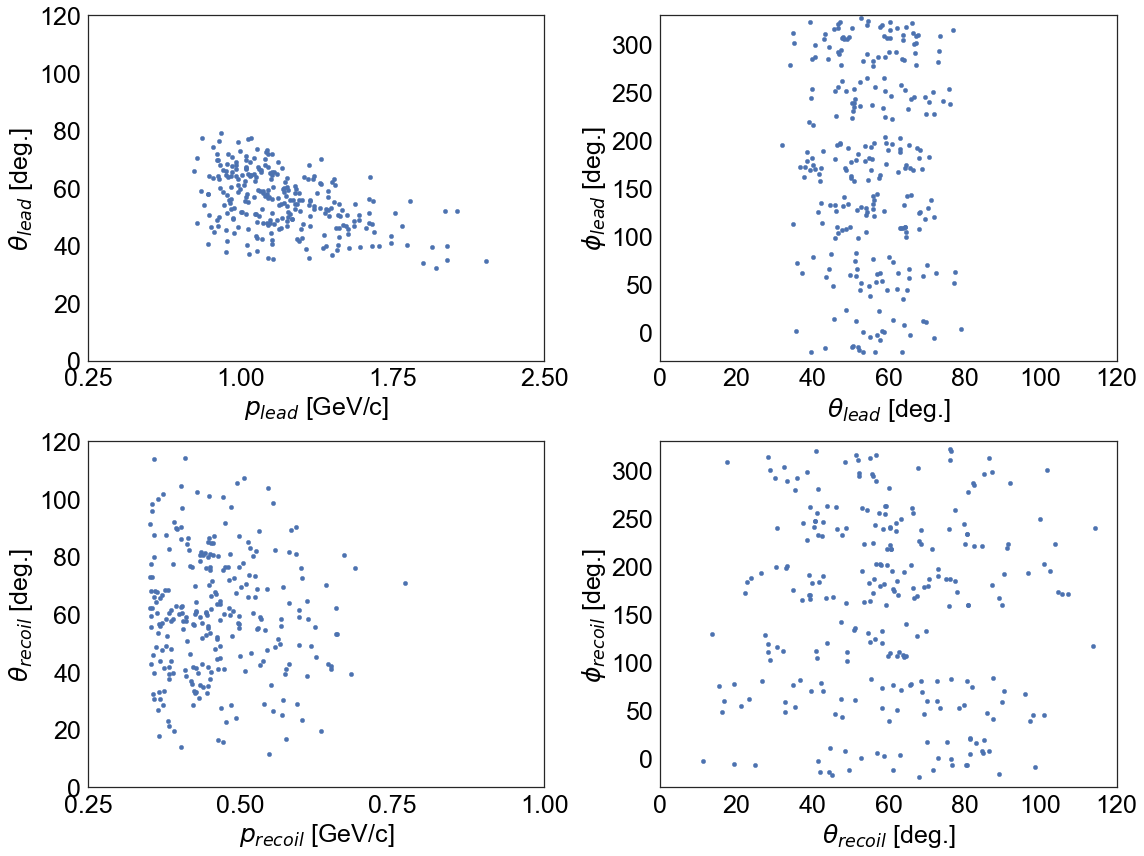

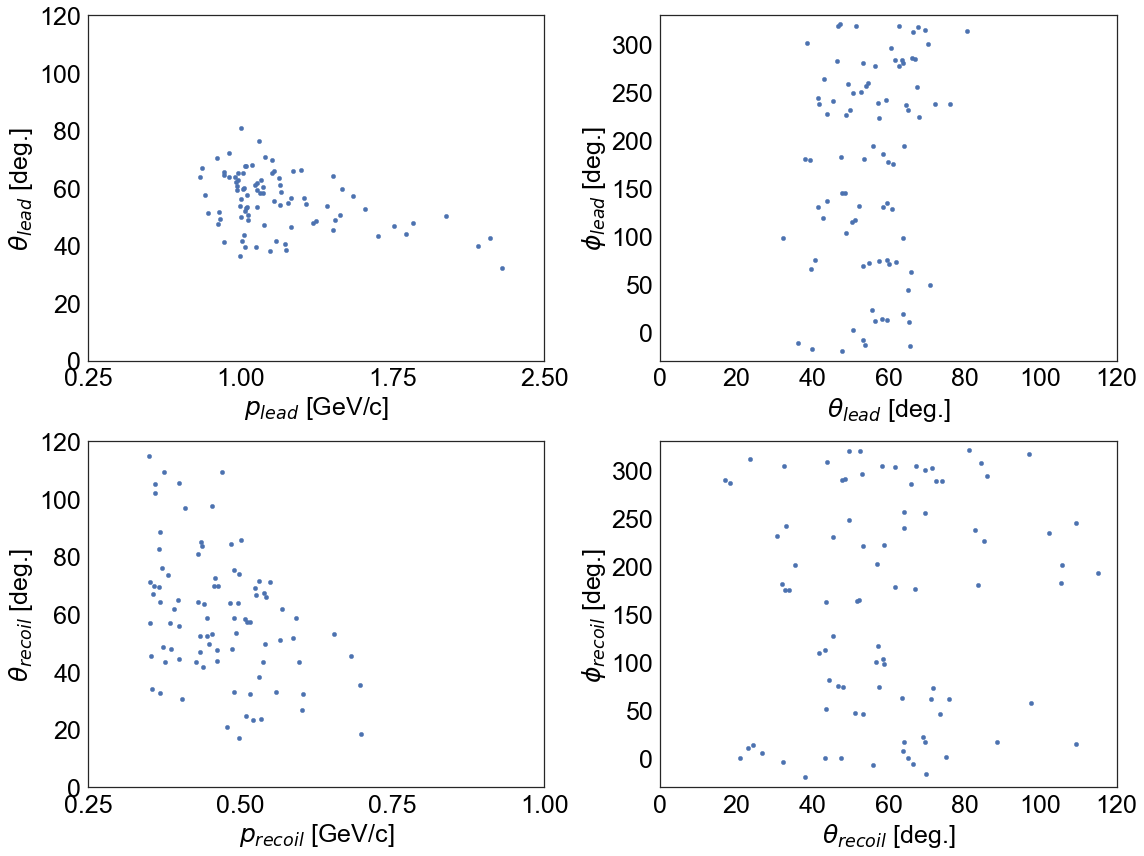

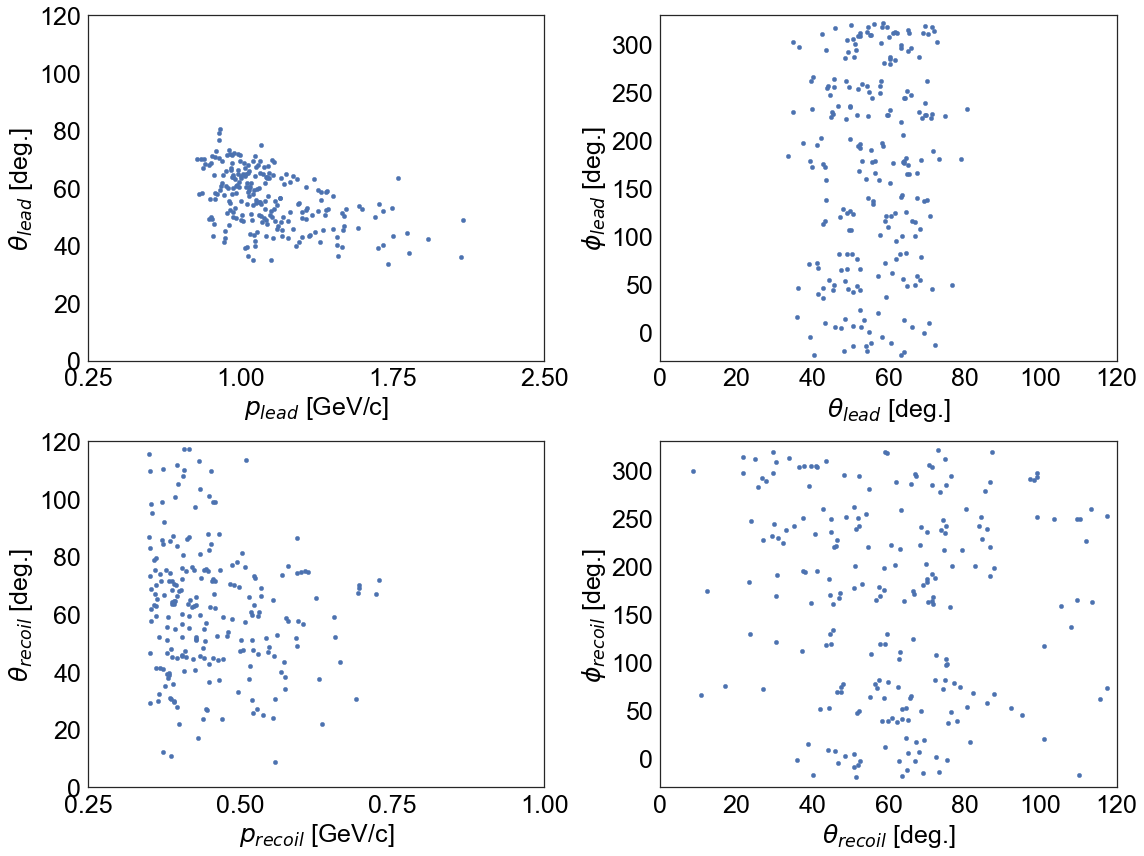

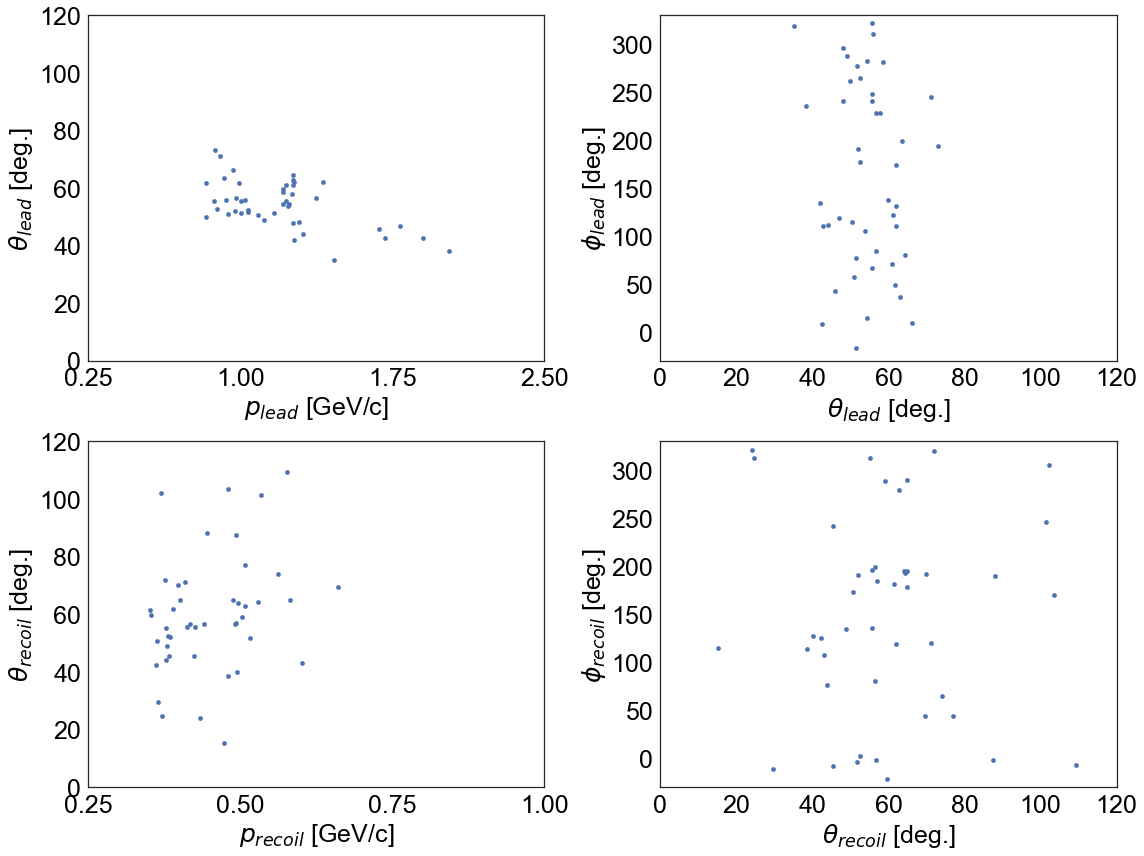

In [10]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig = plt.figure(figsize=(16,12))    
    for i_proton,proton in enumerate(['lead','recoil']):

        P = data300Pmiss600_PrecFid[target]['P'+proton+'_P']
        theta = 180./np.pi*data300Pmiss600_PrecFid[target]['P'+proton+'_theta']
        phi = data300Pmiss600_PrecFid[target]['P'+proton+'_phi']
        
        ax = fig.add_subplot(2,2,2*i_proton+1)
        plt.scatter(P,theta,s=20)
        set_axes(ax,r'$p_{%s}$ [GeV/c]'%proton,r'$\theta_{%s}$ [deg.]'%proton
                 , xlim=(0.25,2.5) if i_proton==0 else (0.25,1.0)
                 , xticks=np.linspace(0.25,2.5,4) if i_proton==0 else np.linspace(0.25,1,4)
                 , ylim=(0,120)
                )       
        
        ax = fig.add_subplot(2,2,2*i_proton+2)
        
        # draw the sectors in the recoil-proton case
#         if proton=='recoil' or proton=='lead':
#             for phi_s in phi_sector:                
#                 plt.plot(theta_line,phi_s,'--',color='red',linewidth=2,alpha=1)
#                 plt.plot([np.average(phi_s),np.average(phi_s)],ax.get_ylim(),'--',color='red',linewidth=2,alpha=1)
#             for phi_min,phi_max in zip(phi_min_array,phi_max_array):
#                 plt.plot(theta_line,phi_min,'--',color='black',linewidth=2,alpha=0.5)
#                 plt.plot(theta_line,phi_max,'--',color='black',linewidth=2,alpha=0.5)
                
#         plt.hist(phi,bins=np.linspace(-30,330,72))
        plt.scatter(theta,phi,s=20)

        set_axes(ax
                 ,r'$\theta_{%s}$ [deg.]'%proton
                 ,r'$\phi_{%s}$ [deg.]'%proton
#                  ,'counts'
                 , xlim=(0,120)
                 , ylim=(-30,330)
                )
#         for phi_s in phi_sector:                
#             plt.plot([np.average(phi_s),np.average(phi_s)],ax.get_ylim(),'--',color='red',linewidth=2,alpha=1)

    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/PleadPrecoil_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)
    
    
# fig = plt.figure(figsize=(16,12))    
# for i_proton,proton in enumerate(['lead','recoil']):

#     P = data300Pmiss600_PrecFid_all['P'+proton+'_P']
#     theta = 180./np.pi*data300Pmiss600_PrecFid_all['P'+proton+'_theta']
#     phi = data300Pmiss600_PrecFid_all['P'+proton+'_phi']
        
#     ax = fig.add_subplot(2,2,2*i_proton+1)
#     plt.scatter(P,theta,s=20)
#     set_axes(ax,r'$p_{%s}$ [GeV/c]'%proton,r'$\theta_{%s}$ [deg.]'%proton
#                  , xlim=(0.25,2.5) if i_proton==0 else (0.25,1.0)
#                  , xticks=np.linspace(0.25,2.5,4) if i_proton==0 else np.linspace(0.25,1,4)
#                  , ylim=(0,120))
#     ax = fig.add_subplot(2,2,2*i_proton+2)
#     plt.hist(phi,bins=np.linspace(-30,330,181))
#     set_axes(ax,r'$\phi_{%s}$ [deg.]'%proton
#                  ,'counts')
# plt.tight_layout()
# outfilename = figures_path+'MeasuredDistributions/PleadPrecoil_all_targets.pdf' 
# print 'saved ' + outfilename
# plt.savefig(outfilename)    

## lab $\phi$ difference between the electron and the recoil proton

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/phi_lab_ep.pdf


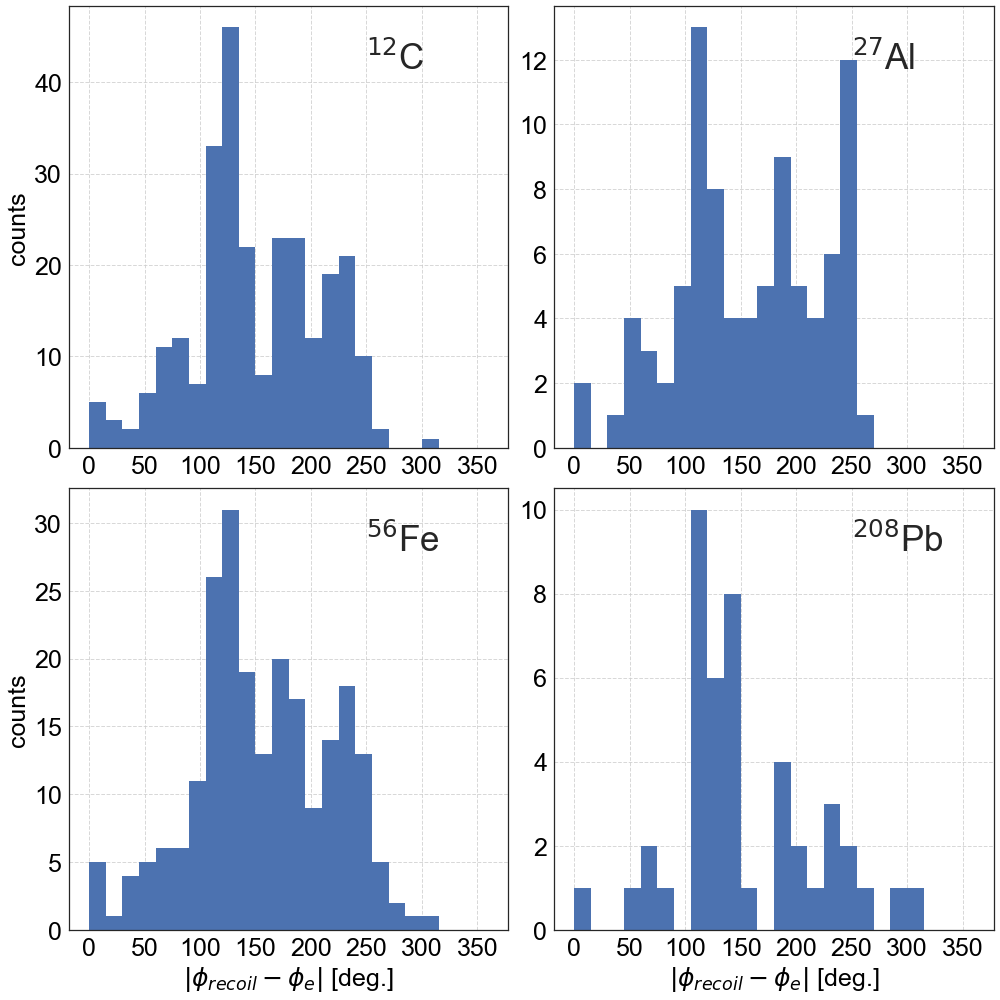

In [11]:
fig = plt.figure(figsize=(14,14))
for i_tgt,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    
    delta_phi = (data300Pmiss600_PrecFid[target]['Precoil_phi']-data300Pmiss600_PrecFid[target]['electron_phi'])
    ax = fig.add_subplot(2,2,i_tgt+1)
    h,bins,_=plt.hist(np.abs(delta_phi),bins=np.linspace(0,360,25))
    plt.text(250,0.9*np.max(h),name,fontsize=35)
    set_axes(ax,r'$|\phi_{recoil} - \phi_{e}|$ [deg.]' if i_tgt>1 else ''
                 ,'counts' if i_tgt==0 or i_tgt==2 else '',do_add_grid=True
                )
plt.tight_layout()
outfilename = figures_path+'MeasuredDistributions/phi_lab_ep.pdf' 
print 'saved ' + outfilename
plt.savefig(outfilename)

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/delta_phi_vs_delta_theta_lab_ep.pdf


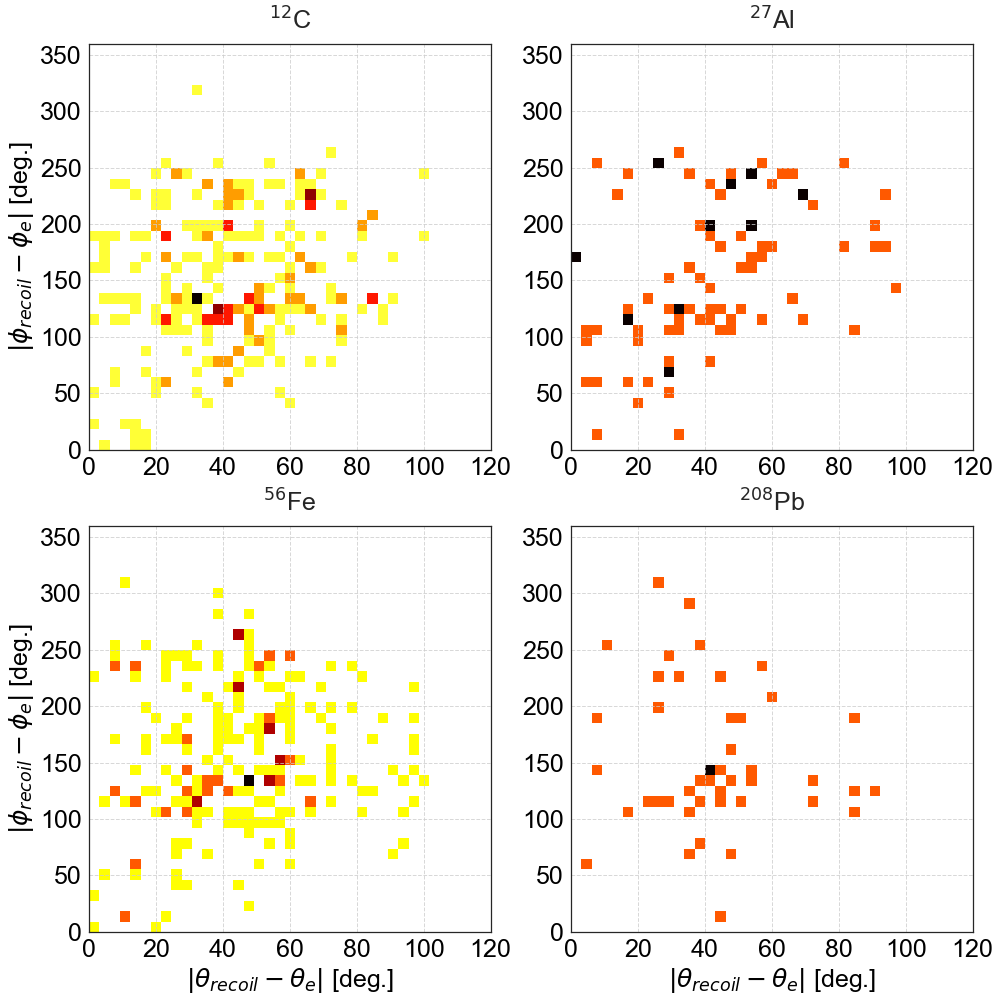

In [12]:
fig = plt.figure(figsize=(14,14))
for i_tgt,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    
    delta_phi = (data300Pmiss600_PrecFid[target]['Precoil_phi']-data300Pmiss600_PrecFid[target]['electron_phi'])
    delta_theta = 180./np.pi*(data300Pmiss600_PrecFid[target]['Precoil_theta']-data300Pmiss600_PrecFid[target]['electron_theta'])

    ax = fig.add_subplot(2,2,i_tgt+1)
    plot_2d_hist( np.abs(delta_theta),np.abs(delta_phi),bins=(np.linspace(0,120,40),np.linspace(0,360,40)),ax=ax)
    set_axes(ax
             ,r'$|\theta_{recoil} - \theta_{e}|$ [deg.]' if i_tgt>=2 else ''
             ,r'$|\phi_{recoil} - \phi_{e}|$ [deg.]' if i_tgt==0 or i_tgt==2 else ''
             ,title=name
             ,do_add_grid=True
                )
plt.tight_layout()
outfilename = figures_path+'MeasuredDistributions/delta_phi_vs_delta_theta_lab_ep.pdf'
print 'saved ' + outfilename
plt.savefig(outfilename)

## the c.m. distributions witouth a cut on $p_{miss}<600$

504 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_C12.pdf
175 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Al27.pdf
475 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Fe56.pdf
108 events
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/MeasuredDistribution_all_Pmiss_Pb208.pdf


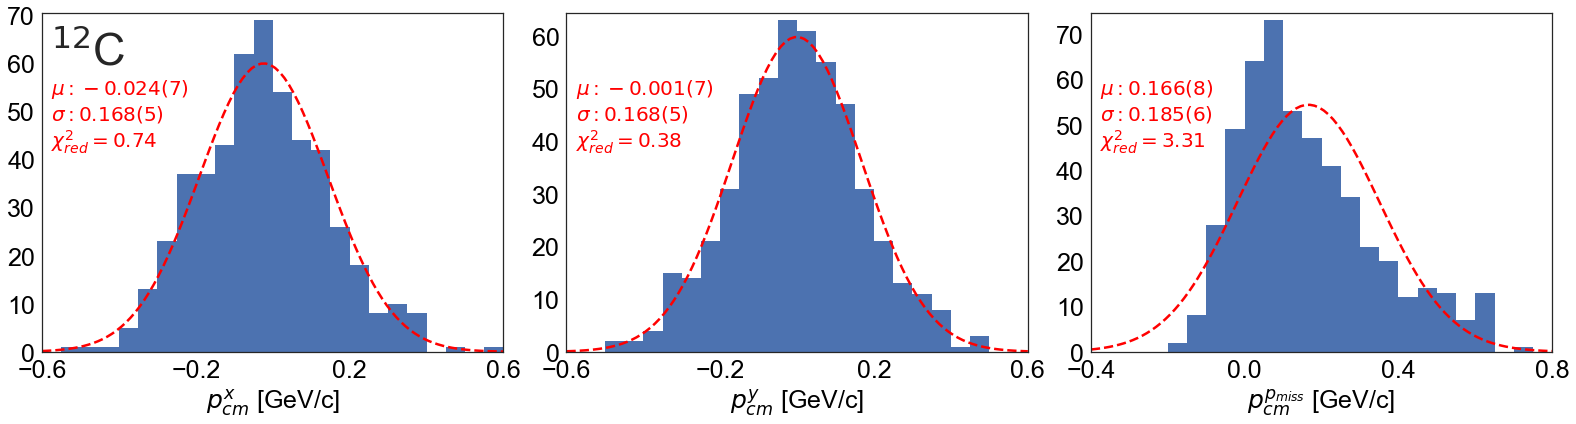

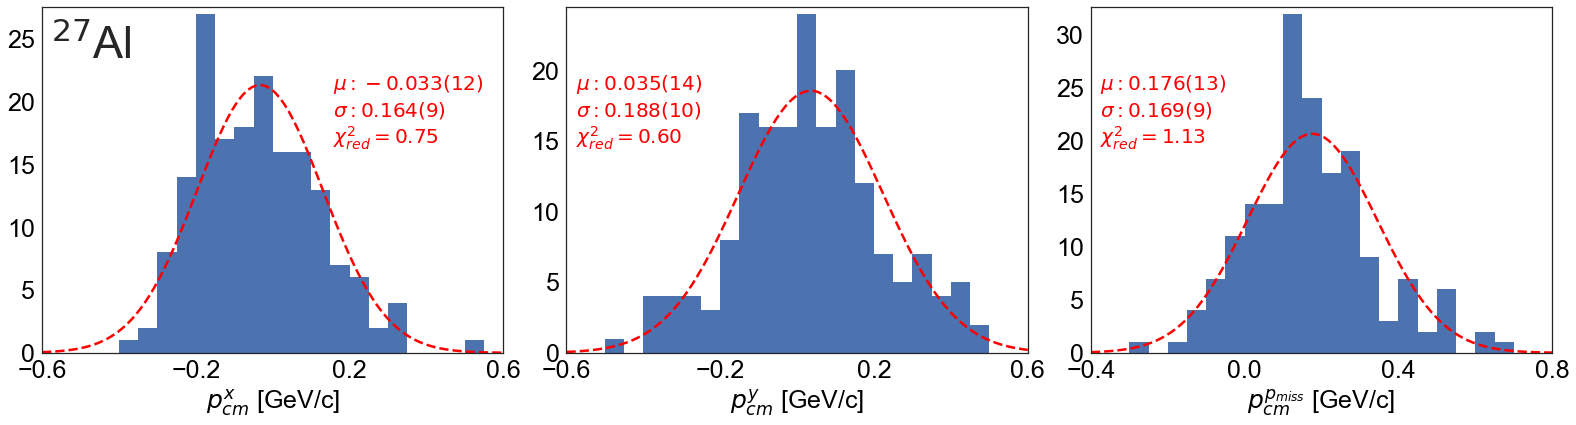

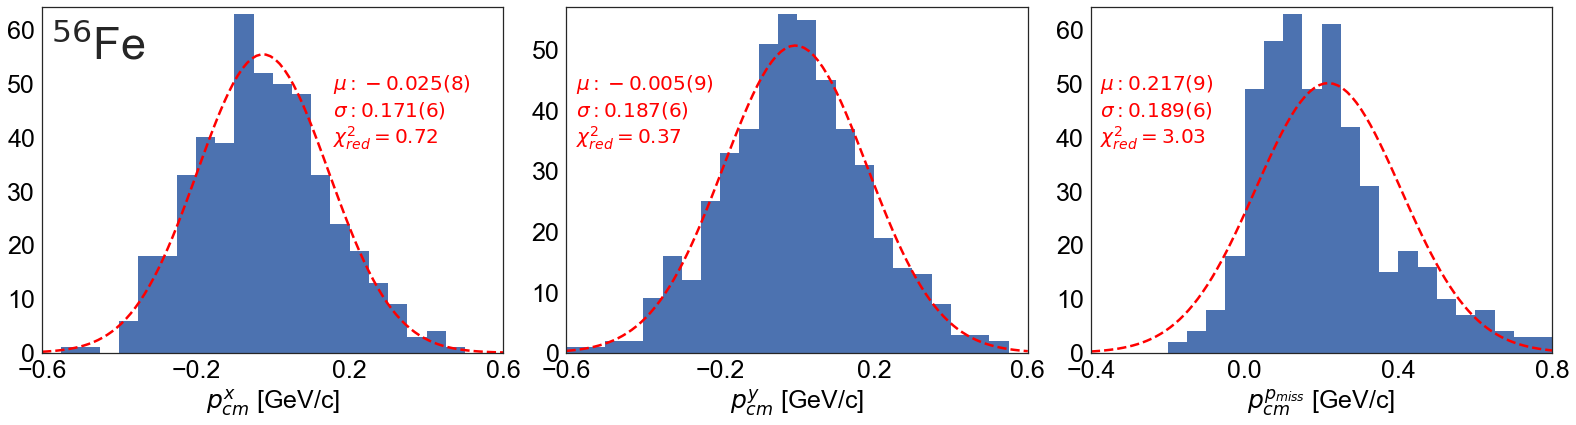

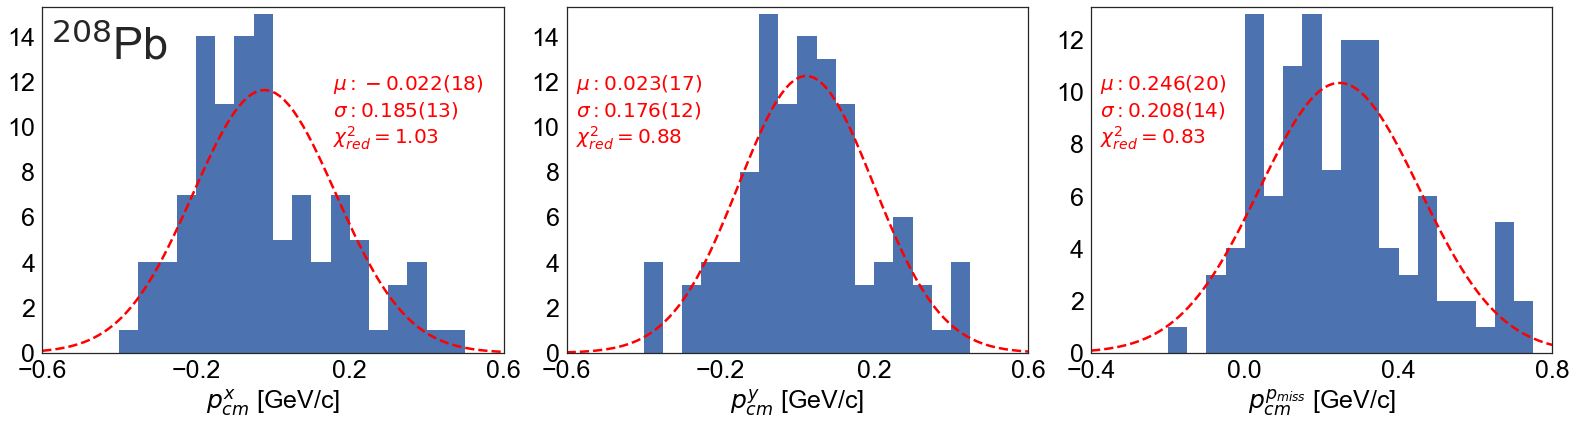

In [55]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
cm_pars_all_Pmiss = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss1000/alltargets_PrecFiducials_dataCMparameters.csv')
for direction in ['x','y']:
    cm_pars_all_Pmiss['sigma_'+direction+'_before_acc_corr'] = np.sqrt(np.square(cm_pars_all_Pmiss['sigma_'+direction+'_unweighted']) - np.square(0.02))
    cm_pars_all_Pmiss['sigma_'+direction+'_before_acc_corr_err'] = cm_pars_all_Pmiss['sigma_'+direction+'Err_unweighted']

for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data_allPmiss_PrecFid[target]['pcm'+direction]
        if i==0: print len(x),'events'
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,25) #16
        h,bins,_=plt.hist( x,   bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        cm_pars_target = cm_pars_all_Pmiss[cm_pars_all_Pmiss['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])

#         i_mean = np.argmax(h)
#         bin_mean = bins[i_mean]
#         mean = bin_mean
        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label, xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/MeasuredDistribution_all_Pmiss_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

## fit with simple binned fit

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_C12.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Al27.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Fe56.pdf
saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/MeasuredDistributions/binned_fits_Pb208.pdf


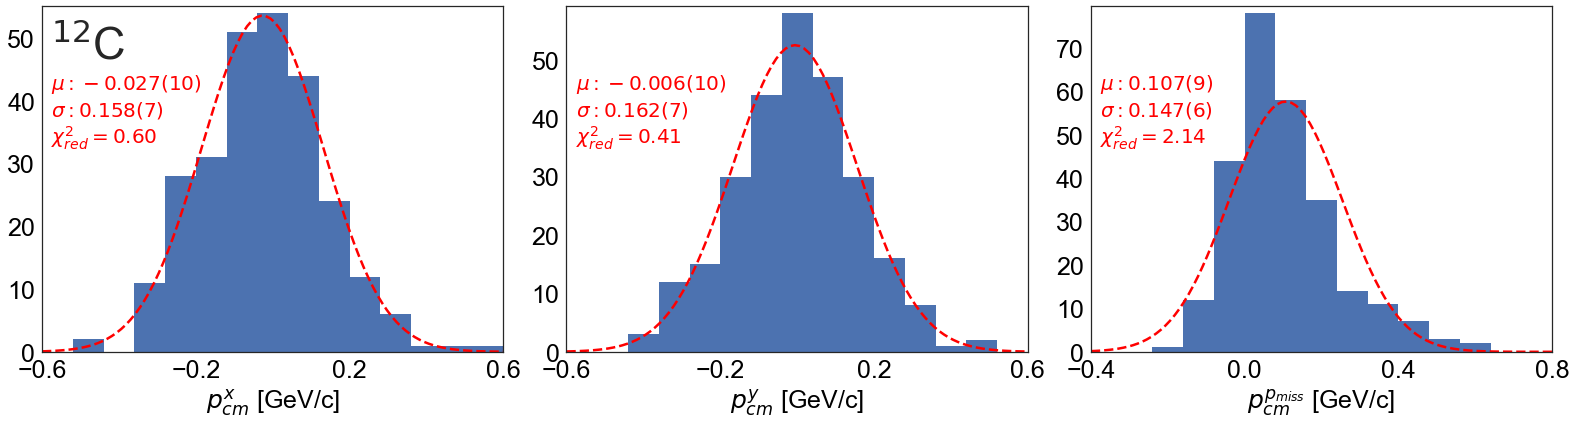

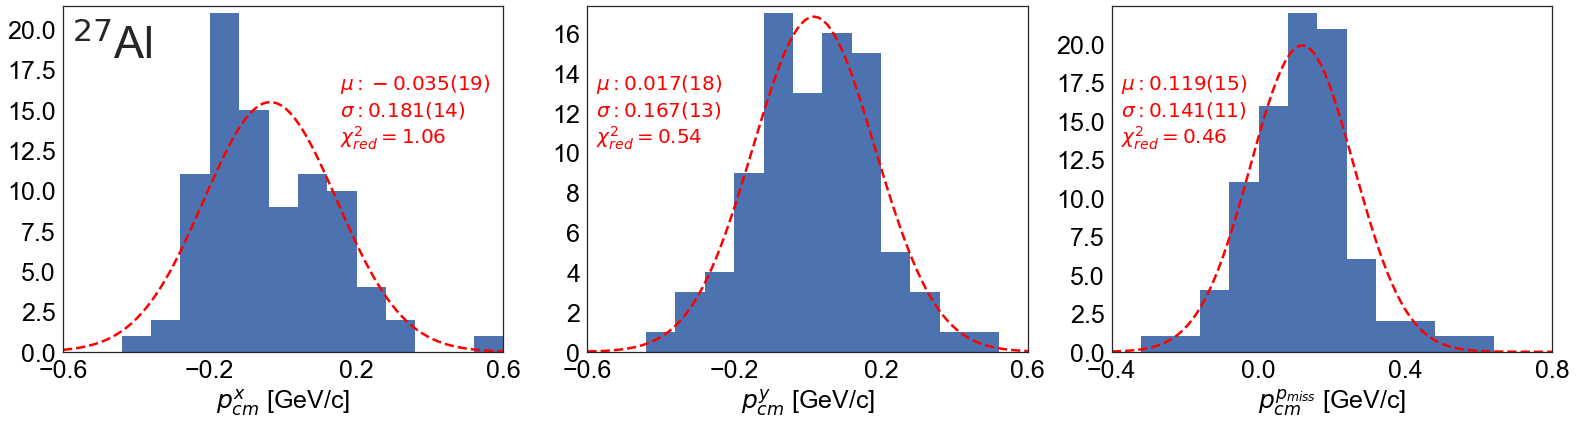

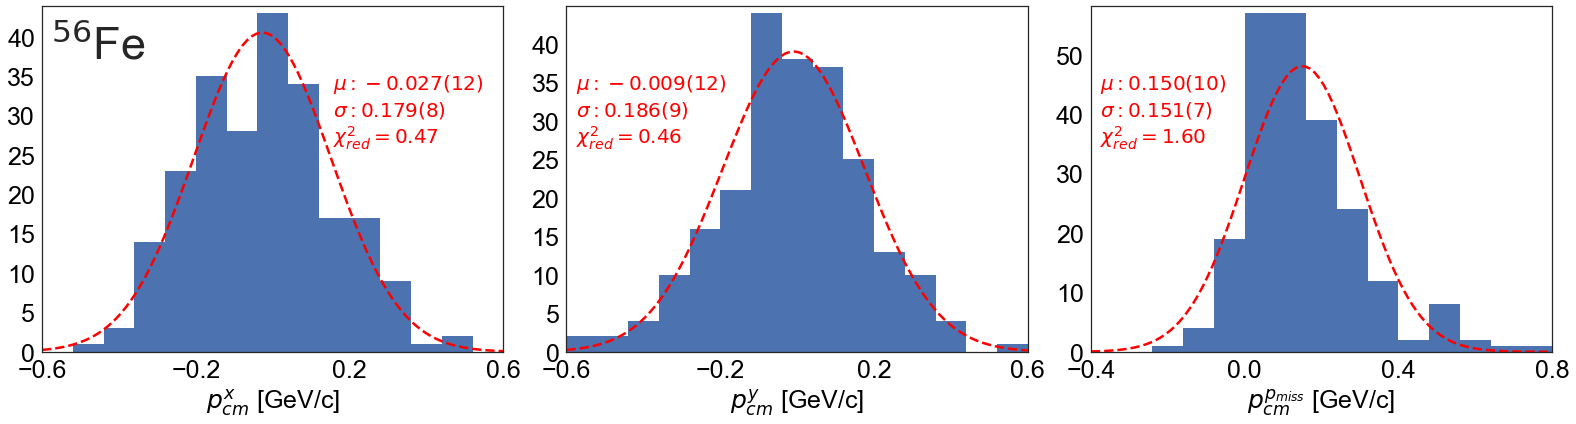

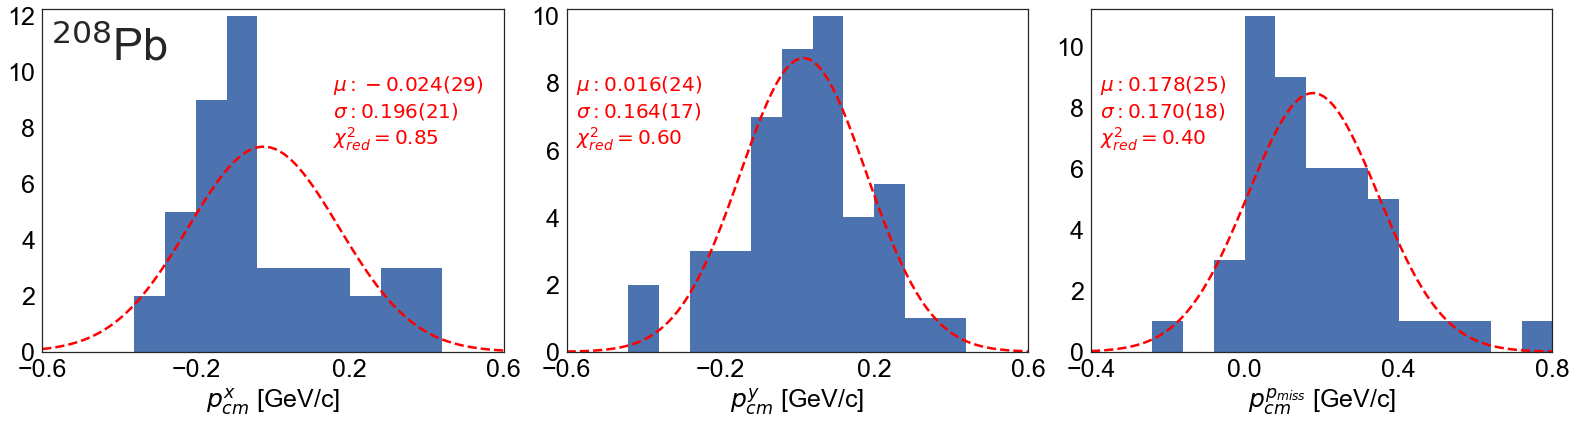

In [14]:
for target,name in zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    fig=plt.figure(figsize=(22,6))
    for i,(cm_pars_dir,direction,label) in enumerate(zip(['x','y','z']
                                                         ,['X','Y','Z']                                             
                                                         ,['x','y','p_{miss}'])):
        ax=fig.add_subplot(1,3,i+1)
        x = data300Pmiss600_PrecFid[target]['pcm'+direction]
        xmin = -0.6 if i<2 else -0.4       
        xmax = 0.6 if i<2 else 0.8
        bins=np.linspace(xmin,xmax,16)
        h,bins,_=plt.hist( x,  bins=bins)
        NormFact = len(x)*(bins[1]-bins[0])
        
        cm_pars_target = cm_pars[cm_pars['target']==name]
        mean = float(cm_pars_target['mean_'+cm_pars_dir+'_unweighted'])
        mean_err = float(cm_pars_target['mean_'+cm_pars_dir+'Err_unweighted'])
        sigma = float(cm_pars_target['sigma_'+cm_pars_dir+'_unweighted'])
        sigma_err = float(cm_pars_target['sigma_'+cm_pars_dir+'Err_unweighted'])
        chi2red = float(cm_pars_target['chi2red_'+cm_pars_dir+'_unweighted'])


        set_axes(ax,'$p_{cm}^{%s}$ [GeV/c]'%label, xticks=np.linspace(xmin,xmax,4))
        x_v = np.linspace(xmin,xmax,100)
        plt.plot( x_v , NormFact*mlab.normpdf(x_v, mean, sigma),'--',color='red',linewidth=2.5)
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(0,1.02*np.max(h))

        xtext = xmin+0.02*(xmax-xmin) 
        if direction=='X': 
            plt.text( xtext, 0.85*np.max(ax.get_ylim()), name , fontsize=45)
        # parametrs on text
        if target!='C12' and direction=='X':
            xtext = xmax-0.37*(xmax-xmin) 
        plt.text( xtext, 0.6*np.max(ax.get_ylim()), '$\\mu:%.3f(%.0f)$\n$\\sigma:%.3f(%.0f)$\n$\chi^{2}_{red}=%.2f$'%(mean,1000*mean_err,sigma,1000*sigma_err,chi2red), color='red' , fontsize=20)

        
    plt.tight_layout()
    outfilename = figures_path+'MeasuredDistributions/binned_fits_'+target+'.pdf' 
    print 'saved ' + outfilename
    plt.savefig(outfilename)

# recoil proton acceptance map - a table of acceptance factors in $p,\theta,\phi$ bins

In [55]:
# acceptance with no fiducials...
pAcceptacneFile = ROOT.TFile("/Users/erezcohen/Desktop/DataMining/GSIM_DATA/PrecoilAcceptance.root")
h = pAcceptacneFile.Get("hRescaled")
hAcceptanceAll = h.Clone("hAcceptanceAll")
hAcceptanceFiducial = h.Clone("hAcceptanceFiducial")
    
p_recoil = ROOT.TVector3()
n_table_lines=1000
i_table_line=0
print r'		$p$ [GeV/c] & $\theta$ [deg.] & $\phi$ [deg.] & acceptance [\%] \\'
print '	\hline'

for binx in range(h.GetXaxis().GetNbins()): # p(recoil) magnitude
    p_recoil_mag = h.GetXaxis().GetBinCenter(binx)
    p_min = h.GetXaxis().GetBinCenter(binx)
    p_max = h.GetXaxis().GetBinCenter(binx) + (h.GetXaxis().GetBinWidth(binx))

    
    for biny in range(h.GetYaxis().GetNbins()): # p(recoil) theta
        p_recoil_theta = h.GetYaxis().GetBinCenter(biny)
        theta_min = h.GetYaxis().GetBinCenter(biny)
        theta_max = h.GetYaxis().GetBinCenter(biny) + (h.GetYaxis().GetBinWidth(biny))

            
        for binz in range(h.GetZaxis().GetNbins()): # p(recoil) phi
            p_recoil_phi = h.GetZaxis().GetBinCenter(binz)
            phi_min =  h.GetZaxis().GetBinCenter(binz)
            phi_max =  h.GetZaxis().GetBinCenter(binz) + (h.GetZaxis().GetBinWidth(binz))

                
            p_recoil.SetMagThetaPhi( p_recoil_mag , math.radians(p_recoil_theta) , math.radians(p_recoil_phi) )
            fiducial = dm.protonFiducial ( p_recoil , 1 )
            acceptance = h.GetBinContent( binx , biny , binz )
            hAcceptanceFiducial.SetBinContent( binx, biny, binz, acceptance if fiducial else 0 )
            print r'		%.2f$\to$%.2f'%(p_min,p_max), r' & (%.1f)$\to$(%.1f)'%(theta_min , theta_max), r' & (%.1f)$\to$(%.1f)'%( phi_min,phi_max),' & %.1f'%acceptance,r' \\'
            print '	\hline'
            i_table_line += 1
            if i_table_line>n_table_lines: break
        if i_table_line>n_table_lines: break                
    if i_table_line>n_table_lines: break

		$p$ [GeV/c] & $\theta$ [deg.] & $\phi$ [deg.] & acceptance [\%] \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-32.5)$\to$(-27.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-27.5)$\to$(-22.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-22.5)$\to$(-17.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-17.5)$\to$(-12.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-12.5)$\to$(-7.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-7.5)$\to$(-2.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (-2.5)$\to$(2.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (2.5)$\to$(7.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (7.5)$\to$(12.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (12.5)$\to$(17.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (17.5)$\to$(22.5)  & 0.0  \\
	\hline
		0.34$\to$0.36  & (-1.7)$\to$(1.7)  & (22.5)$\to$(27.5)  & 0.0  \\
	\hline
		0.34

# In addition to Figs 11-14, would you provide a table showing the mean and width (uncertainty) of generated and reconstructed $\sigma_x$ and  $\sigma_y$?}

In [10]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

In [11]:


columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["NoPrecFiducials","PrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    
    
    # weighted average
    sigma_x, Dsigma_x = cm_pars['sigma_x_before_acc_corr'], cm_pars['sigma_x_before_acc_corr_err']
    sigma_y, Dsigma_y = cm_pars['sigma_y_before_acc_corr'], cm_pars['sigma_y_before_acc_corr_err']
    sigma_t = (sigma_x/np.square(Dsigma_x)+sigma_y/np.square(Dsigma_y))/( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y))
    cm_pars['sigma_t_before_acc_corr'] = sigma_t    
    Dsigma_t = np.sqrt(1./( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y) ))
    cm_pars['sigma_t_before_acc_corr_err'] = Dsigma_t
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
cm_parameters[Fiducials]

targets = ['C','Al','Fe','Pb']
target_names = [r'$^{12}$C',r'$^{27}$Al',r'$^{56}$Fe',r'$^{208}$Pb']
colors = ['red','blue','forestgreen','purple']
As = [12,27,56,208]
Neep = [7598,2573,8558,2635]
Neepp = [266,88,227,45]
simulation_results = dict()

for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = "simulations_"+Fiducials+"_"+target
        simulation_results[test_name] = pd.concat([pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
                                                   ,pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/Nominal_more_"+target+".csv")])
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

115200 events in  simulations_PrecFiducials_C
114734 events in  simulations_PrecFiducials_Al
113800 events in  simulations_PrecFiducials_Fe
85538 events in  simulations_PrecFiducials_Pb


In [12]:
def interval_68_from_start_point( a=None, start_x = -np.inf, dx=0.001 , debug=0):
    '''
    return the end point of the 68% interval starting at start_x
    '''
    end_x = start_x
    frac = 0
    N_tot = len(a[a<np.inf])
    step = 0
    while( frac < 0.68 ):#{
        end_x = end_x + dx
        N_start_end = len(a[(a>start_x)&(a<end_x)])
        frac = float(N_start_end)/N_tot
        step += 1
        if step>1000: break
    #}
    if debug: print 'frac:',frac
    return end_x

def find_smallest_interval( a=None, dx=0.001 ):
    l_interval = 10000
    for start_x in np.arange(np.min(a),np.mean(a)+np.std(a),dx):
        # print 'start_x:',start_x
        end_x = interval_68_from_start_point(start_x=start_x,a=a,dx=dx)
        if ((end_x-start_x) < l_interval):
            l_interval = end_x-start_x
            interval = [start_x,end_x]
    return interval

def plot_cm_direction_binned_confidence68(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,ax=None,A=12,poly_degree=3
                             ,direction='x',colors=['blue','royalblue'],s=1
                             ,Nbins_st_rec=10 # GeV/c
                             ,do_add_1Ddist_in_slices=False
                             ,debug=0
                             ,do_zoom_in=False
                             ,do_add_legend=True):

        
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    if debug>1: print cm_tgt
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])
    
    title = cm_tgt['target'].to_string(index=False) + ', $'+direction+'-direction$'
    if debug: print title

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    if debug: print '\sigma_t roi: %.3f->%.3f GeV/c'%(roi_min,roi_max)
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]
    
    
    gen,rec = sims['gen_Sigma_t'],sims['rec_sigma_'+direction]
    if do_zoom_in:        bins = np.linspace( 0.1 , 0.26 , 50)
    else:        bins=np.linspace( 0.02 , 0.3 , 50 )
    ax.hist2d(gen,rec,cmap=colors[2],label='generated vs. reconstructed',bins=bins)#,norm=LogNorm())


    # bin in rec. sigma_t
    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up=[],[],[],[],[]
    bin_st_rec_width = roi_width/Nbins_st_rec
    if debug:  print 'bin_st_rec_width:',bin_st_rec_width 
    if do_add_1Ddist_in_slices:
        fig_1Ddist_in_slices = plt.figure(figsize=(16,8))

    
    for i_bin in range(Nbins_st_rec):
        if debug: print 'i_bin in reconstructed sigma(t):',i_bin
        bin_st_rec_center = roi_min + bin_st_rec_width*(i_bin+0.5)
        bin_st_rec_dw = bin_st_rec_center - 0.5*bin_st_rec_width
        bin_st_rec_up = bin_st_rec_center + 0.5*bin_st_rec_width

        sims_bin = roi_sims[(roi_sims['rec_sigma_'+direction]>bin_st_rec_dw)
                            &(roi_sims['rec_sigma_'+direction]<bin_st_rec_up)]
        # find the narrowest window with 68% interval
        interval = find_smallest_interval(a=sims_bin['gen_Sigma_t'],dx=0.001)
        sims_in_interval = sims_bin['gen_Sigma_t'][(sims_bin['gen_Sigma_t']>interval[0])&(sims_bin['gen_Sigma_t']<interval[1])]
        bin_st_gen_mean = np.mean(sims_in_interval)
        bin_st_gen_err_up = interval[1] - bin_st_gen_mean
        bin_st_gen_err_dw = bin_st_gen_mean - interval[0]
        
        if debug>1: print 'bin in \sigma_t: (%.3f-%.3f)'%(bin_st_rec_dw,bin_st_rec_up)
        if debug>1: print 'gen \sigma_t: (%.3f-%.3f)'%(bin_st_gen_err_dw,bin_st_gen_err_up)
            
        if do_add_1Ddist_in_slices:
            ax_1Ddist_in_slices = fig_1Ddist_in_slices.add_subplot(Nbins_st_rec/4+1,4,i_bin+1)
            ax_1Ddist_in_slices.hist( sims_bin['gen_Sigma_t'] , bins=30 , color=colors[1])
            set_axes(ax_1Ddist_in_slices,r'gen. $\sigma$ [GeV/c]' if i_bin>(Nbins_st_rec-5) else ''
                     ,title=r'$%.3f'%bin_st_rec_dw+'<\sigma_{'+direction+'}^{rec}<%.3f$'%bin_st_rec_up
                     ,xticks=np.linspace(np.min(sims_bin['gen_Sigma_t']),np.max(sims_bin['gen_Sigma_t']),3)
                     ,fontsize=20)
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean,bin_st_gen_mean] , ax_1Ddist_in_slices.get_ylim() , '-' , color='black')
            ax_1Ddist_in_slices.plot( [interval[0],interval[0]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.plot( [interval[1],interval[1]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.yaxis.set_major_formatter(NullFormatter())
                                
        if bin_st_gen_mean is not np.nan:
            rec_bins.append(bin_st_rec_center)
            rec_bins_err.append(bin_st_rec_width)
            gen_bins.append(bin_st_gen_mean)
            gen_bins_err_dw.append(bin_st_gen_err_dw)
            gen_bins_err_up.append(bin_st_gen_err_up)
            
    if debug: print 'rec_bins_err:',rec_bins_err
    if debug: print 'gen_bins_err_dw:',gen_bins_err_dw,'gen_bins_err_up:',gen_bins_err_up

    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up = np.array(rec_bins),np.array(rec_bins_err),np.array(gen_bins),np.array(gen_bins_err_dw),np.array(gen_bins_err_up)
    ax.errorbar(x=gen_bins,xerr=[gen_bins_err_dw,gen_bins_err_up],y=rec_bins,yerr=0.5*rec_bins_err,fmt='o',color='black')
    sigma_gen_rec_bins = (gen_bins , [gen_bins_err_dw,gen_bins_err_up] , rec_bins , 0.5*rec_bins_err )
    
    if do_add_1Ddist_in_slices: 
        plt.tight_layout()
        plt.savefig(figures_path+'1Ddist_in_slices/'+'A_%d'%A+'_direction_'+direction+'_'+extraname+'.png')

    # fit a polynomial of order poly_degree
    if debug: print "gen_bins:",gen_bins,"\nrec_bins:",rec_bins

    popt,cov = np.polyfit( gen_bins , rec_bins , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace( np.min(gen_bins) , np.max(gen_bins) , 500)
    poly = np.poly1d(popt)
    ax.plot( x , poly(x),'-',color='black',linewidth=2,label='best fit')    

    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    if debug: print 'sigma_meas:',sigma_meas
    if debug: print 'corr_value:',corr_value

    label_corr = '$%.3f$'%(corr_value)
    ax.plot( np.linspace(np.min(ax.get_xlim()),corr_value,len(x)) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    ax.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[1])
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value) 
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)    
    # projection of the measured uncertainties
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_stat,len(x)) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_stat,len(x)) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    ax.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    ax.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True , xlim=(0.02,0.3), ylim=(0.02,0.3)
             ,title=title)
    plt.tight_layout() 
    if do_zoom_in:
        ax.set_xlim(find_x_poly(poly,sigma_meas - 3*sigma_meas_err),find_x_poly(poly,sigma_meas + 3*sigma_meas_err) ); 
        ax.xaxis.set_major_locator(LinearLocator(4)); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_ylim(sigma_meas - 3*sigma_meas_err,sigma_meas +3*sigma_meas_err);
        ax.yaxis.set_major_locator(LinearLocator(4)); ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # systematical uncertainty
    # by creating a bin from the rec. around the measured data,
    # and asking what is the 1\sigma width of the generated in this bin
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    #     sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - sigma_meas_err))
    #                              &(roi_sims['rec_sigma_'+direction]<(sigma_meas + sigma_meas_err))]        
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    ax.errorbar(x=[corr_value],xerr=[bin_st_gen_std]
                ,y=[sigma_meas-0.015],yerr=[0.5*bin_st_rec_width],fmt='o',color='grey',linewidth=3,capthick=3)


    corr_val_err_sys = bin_st_gen_std 
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_sys'+extraname,corr_val_err_sys)
    label_unc_sys = '$(\\pm %.0f)_{sys.}$'%(1000*corr_val_err_sys)

    # projection of the systematical uncertainties
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    ax.plot( [corr_value+corr_val_err_sys,corr_value+corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-')
    ax.plot( [corr_value-corr_val_err_sys,corr_value-corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    
    # total uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_err_sys))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- ---         

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_tot'+extraname,0.5*(corr_val_dw_err_tot+corr_val_up_err_tot))

    
    ax.plot( [0,0] , [0,0] , color=colors[0], linewidth=3,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    if do_add_legend: ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot , sigma_gen_rec_bins

In [18]:
poly_degree = 2 # fit polynomial degree
extraname='confidence68'
sigma_gen_rec_bins_dict = dict()
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    cv,cvuerr,cvderr, sigma_gen_rec_bins = plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=False)
    sigma_gen_rec_bins_dict[target+'x'] = sigma_gen_rec_bins
    ax=fig.add_subplot(2,2,2)    
    cv,cvuerr,cvderr, sigma_gen_rec_bins = plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)
    sigma_gen_rec_bins_dict[target+'y'] = sigma_gen_rec_bins
    fig.tight_layout()     

In [21]:
print r'		$\sigma_t^{gen.}$ [GeV/c] & $\sigma_t^{rec.}$ [GeV/c] \\'
print '	\hline'
#         print '	\endhead'


for i,(A,target,target_name) in enumerate(zip(As[0:],targets[0:],target_names[0:])):
    for direction in ['x','y']:
        print r'		\multicolumn{2}{c}{'+target_name+', '+direction+'-direction'+r'} \\'
        print '	\hline'
        gen_bins , [gen_bins_err_dw,gen_bins_err_up] , rec_bins , rec_bins_err = sigma_gen_rec_bins_dict[target+direction]
        for gen_bin,gen_bin_err_dw,gen_bin_err_up,rec_bin,rec_bin_err in zip(gen_bins , gen_bins_err_dw,gen_bins_err_up , rec_bins , rec_bins_err):
            print r'$%.3f^{+%.3f}_{-%.3f}$ & $%.3f\pm%.3f$ \\'%(gen_bin,gen_bin_err_dw,gen_bin_err_up,rec_bin,rec_bin_err)
            print '	\hline'    

		$\sigma_t^{gen.}$ [GeV/c] & $\sigma_t^{rec.}$ [GeV/c] \\
	\hline
		\multicolumn{2}{c}{$^{12}$C, x-direction} \\
	\hline
$0.130^{+0.004}_{-0.003}$ & $0.145\pm0.001$ \\
	\hline
$0.133^{+0.004}_{-0.003}$ & $0.147\pm0.001$ \\
	\hline
$0.136^{+0.003}_{-0.004}$ & $0.150\pm0.001$ \\
	\hline
$0.137^{+0.004}_{-0.004}$ & $0.153\pm0.001$ \\
	\hline
$0.140^{+0.005}_{-0.003}$ & $0.156\pm0.001$ \\
	\hline
$0.142^{+0.004}_{-0.004}$ & $0.158\pm0.001$ \\
	\hline
$0.145^{+0.004}_{-0.004}$ & $0.161\pm0.001$ \\
	\hline
$0.147^{+0.005}_{-0.004}$ & $0.164\pm0.001$ \\
	\hline
$0.149^{+0.005}_{-0.004}$ & $0.167\pm0.001$ \\
	\hline
$0.151^{+0.005}_{-0.004}$ & $0.169\pm0.001$ \\
	\hline
		\multicolumn{2}{c}{$^{12}$C, y-direction} \\
	\hline
$0.135^{+0.004}_{-0.004}$ & $0.148\pm0.001$ \\
	\hline
$0.137^{+0.004}_{-0.004}$ & $0.151\pm0.001$ \\
	\hline
$0.140^{+0.004}_{-0.004}$ & $0.153\pm0.001$ \\
	\hline
$0.142^{+0.005}_{-0.004}$ & $0.156\pm0.001$ \\
	\hline
$0.144^{+0.005}_{-0.004}$ & $0.159\pm0.001$ \\
	\hlin

# Rev. 3: 
It would also be good to see if there is any sensitivity in the shapes of these momentum distributions in figs 3-6 to the excitation energy of the A-2 system.
			Particularly for the lighter nuclei.  From what I understand you shouldn't see anything for SRC pairs,
			but it could be a good cross-check and may be worth mentioning in the paper if it is easily available from the analysis?

-231.336 205.443
-231.336 205.443
saving /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/pcmXYvsEexcitation_C12.pdf
-138.612 181.965
-138.612 181.965
saving /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/pcmXYvsEexcitation_Al27.pdf
-102.951 239.233
-102.951 239.233
saving /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/pcmXYvsEexcitation_Fe56.pdf
-12.035 201.231
-12.035 201.231
saving /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/pcmXYvsEexcitation_Pb208.pdf


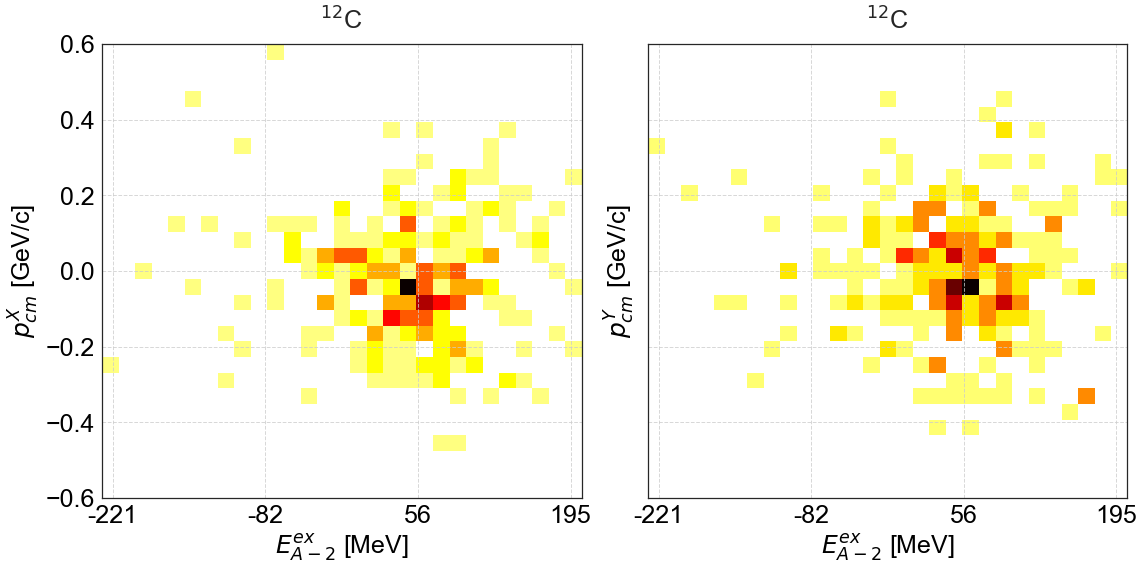

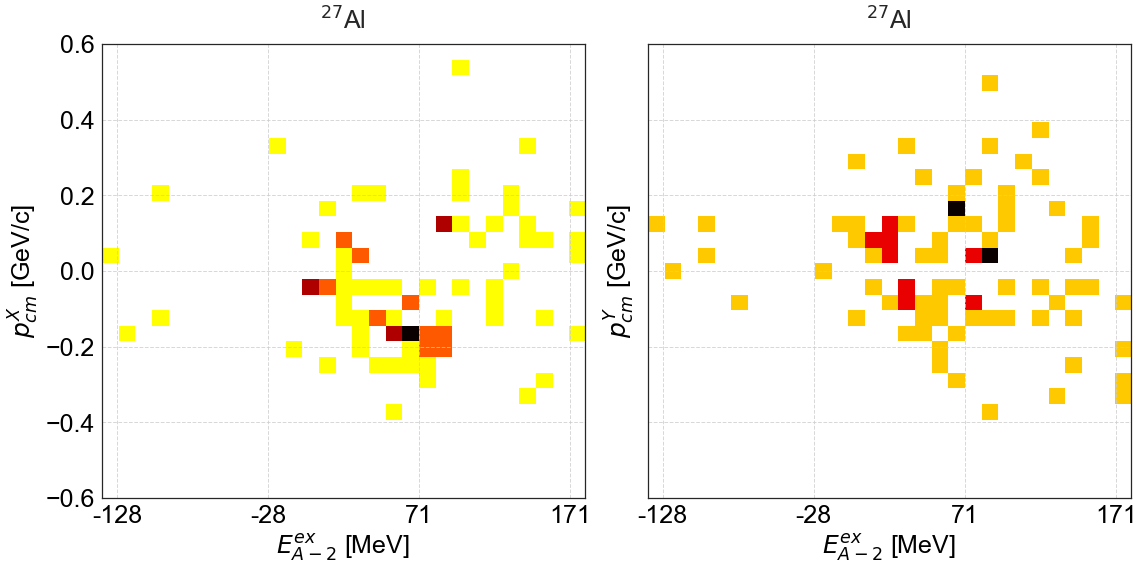

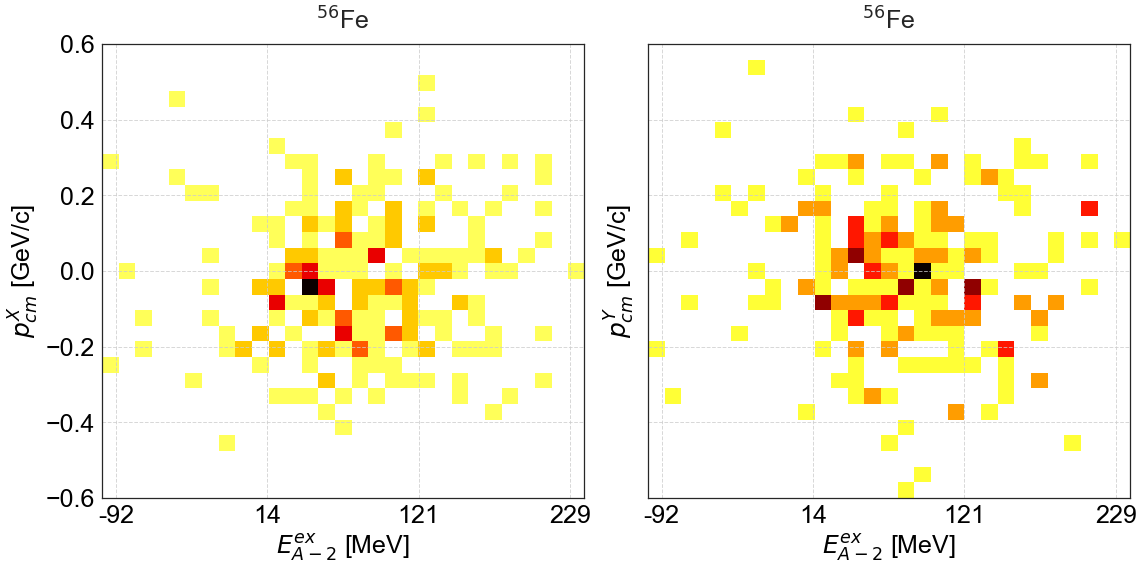

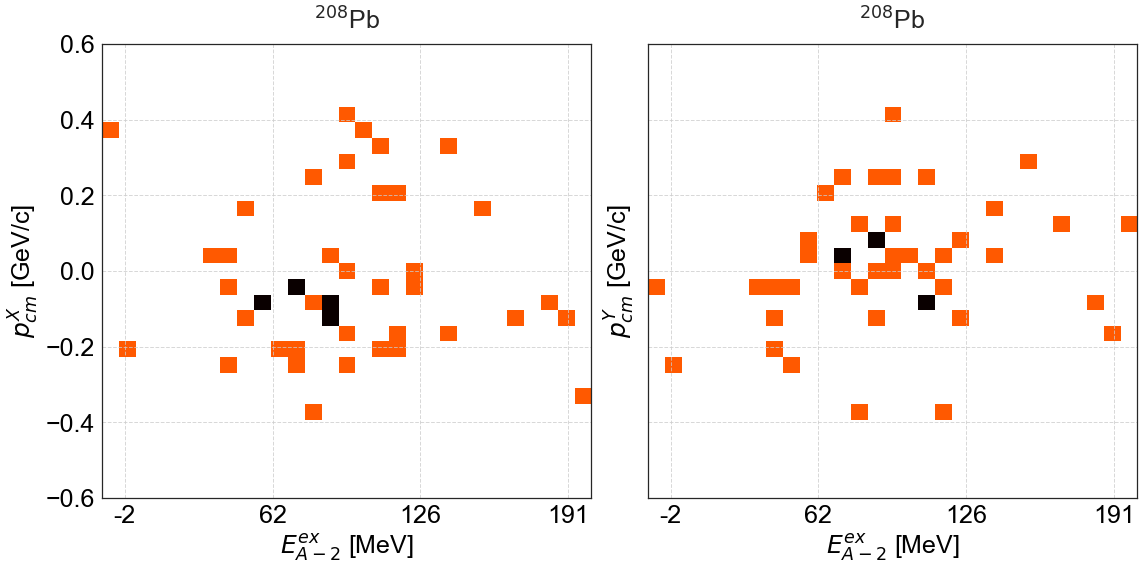

In [10]:
for target,name,m_A,m_A_2 in zip(['C12','Al27','Fe56','Pb208']                    
                            ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']
                                 ,[11.188,25.13,52.02,193.00]                          
                                 ,[9.327,23.277,50.244,191.866]):
    Nbins = 30
    fig=plt.figure(figsize=(16,8))
    for i_dir,direction in enumerate(['X','Y']):
        
        DataSet = data300Pmiss600_PrecFid[target]
        pcm_direction = DataSet['pcm'+direction]
        pcm = np.sqrt(np.square(DataSet['pcmX'])+np.square(DataSet['pcmY'])+np.square(DataSet['pcmZ']))        
        T_A_2 = np.square(pcm)/(2.*m_A_2)
        omega = DataSet['omega']

        Plead_P = DataSet['Plead_P']
        Elead = np.sqrt(np.square(Plead_P) + np.square(0.938))
        Tlead = Elead - 0.938

        Precoil_P = DataSet['Precoil_P']
        Erecoil = np.sqrt(np.square(Precoil_P) + np.square(0.938))
        Trecoil = Erecoil - 0.938

        #         Eex = 1000*( (m_A+omega) - (Elead+Erecoil+m_A_2+T_A_2) ) 
        Eex = 1000*( (omega) - Tlead - Trecoil - T_A_2 ) 


        print np.min(Eex),np.max(Eex)
        ax=fig.add_subplot(1,2,i_dir+1)
        #         plt.hist(Eex , bins=50)
        plot_2d_hist( Eex , pcm_direction 
                     , bins=(np.linspace(np.min(Eex),np.max(Eex),Nbins),np.linspace(-0.6,0.6,Nbins)),ax=ax)
        set_axes(ax
                 ,r'$E^{ex}_{A-2}$ [MeV]',r'$p_{cm}^{'+direction+'}$ [GeV/c]'
                 ,title=name
                 ,xticks=np.linspace(np.min(Eex)+10,np.max(Eex)-10,4)
                 ,do_add_grid=True
                )
        if i_dir>0: ax.get_yaxis().set_major_formatter(NullFormatter())
        ax.get_xaxis().set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
    filename = figures_path+'pcmXYvsEexcitation'+'_'+target+'.pdf'
    print 'saving',filename
    plt.savefig(filename)

saving /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/Eexcitation_all_targets.pdf


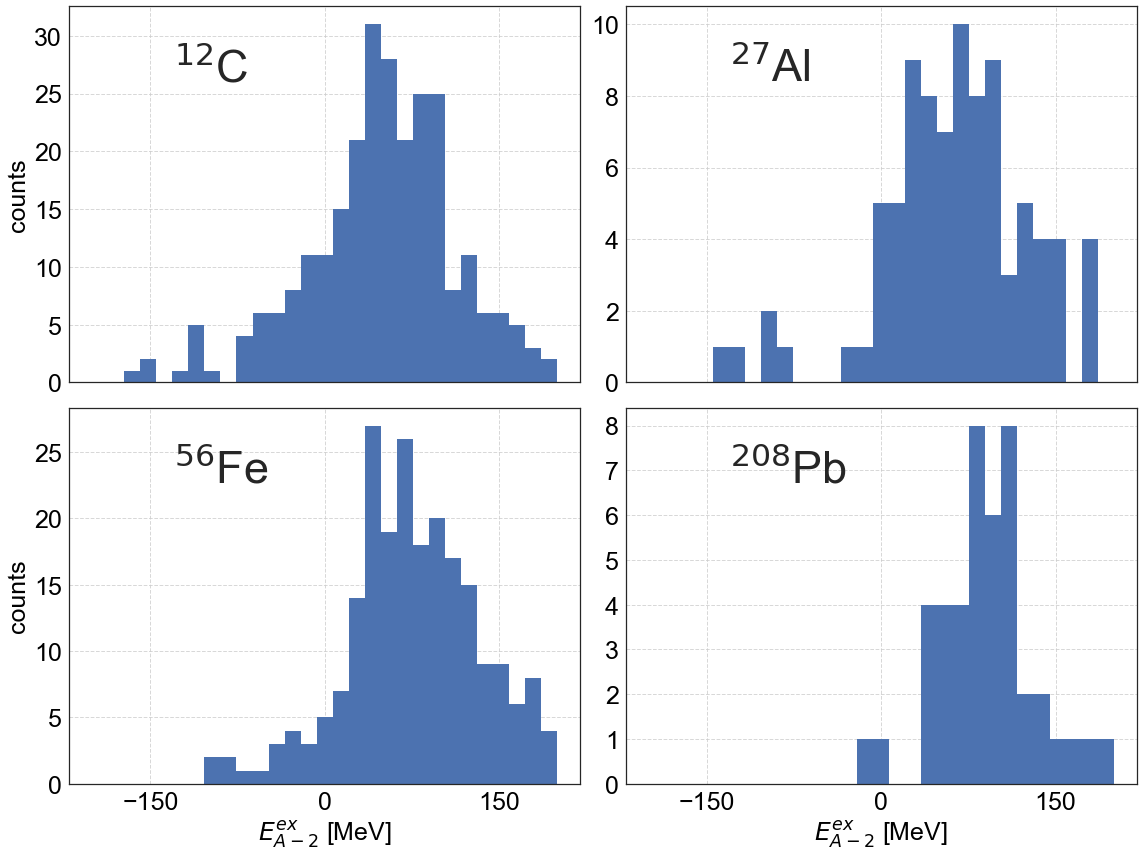

In [25]:
fig=plt.figure(figsize=(16,12))
for i_A,(target,name,A) in enumerate(zip(['C12','Al27','Fe56','Pb208']                    
                                         ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']
                                         ,[12,27,56,208])):
    Nbins = 30
    DataSet = data300Pmiss600_PrecFid[target]
    pcm = np.sqrt(np.square(DataSet['pcmX'])+np.square(DataSet['pcmY'])+np.square(DataSet['pcmZ']))        
    T_A_2 = np.square(pcm)/(2.*(A-2.)*0.938)
    omega = DataSet['omega']

    Plead_P = DataSet['Plead_P']
    Elead = np.sqrt(np.square(Plead_P) + np.square(0.938))
    Tlead = Elead - 0.938

    Precoil_P = DataSet['Precoil_P']
    Erecoil = np.sqrt(np.square(Precoil_P) + np.square(0.938))
    Trecoil = Erecoil - 0.938

    Eex = 1000*( (omega) - Tlead - Trecoil - T_A_2 ) 

    ax=fig.add_subplot(2,2,i_A+1)
    plt.hist(Eex , bins=np.linspace(-200,200,30))
    set_axes(ax,r'$E^{ex}_{A-2}$ [MeV]' if i_A>=2 else  ''
             ,r'counts' if i_A==0 or i_A==2 else ''
                 ,xticks=[-150,0,150]#np.linspace(np.min(Eex)+10,np.max(Eex)-10,4)
                 ,do_add_grid=True
                )
    plt.text(-130,0.8*np.max(ax.get_ylim()),name,fontsize=45)
    if i_A<2: ax.get_xaxis().set_major_formatter(NullFormatter())
#     ax.get_xaxis().set_major_formatter(FormatStrFormatter('%d'))
    plt.tight_layout()
filename = figures_path+'Eexcitation'+'_all_targets.pdf'
print 'saving',filename
plt.savefig(filename)

# others

In [16]:
import kafe
from kafe.function_library import gauss
import iminuit

ImportError: No module named kafe

In [ ]:

x = data300Pmiss600_PrecFid['C12']['pcmY']
h, edges = np.histogram(x, bins=bins)
h =h.astype(np.float)/np.sum(h)
centers = 0.5*(edges[:-1] + edges[1:]) ; bin_width = centers[1]-centers[0]

hdataset = kafe.Dataset([centers, h])
# hdataset.add_error_source('y', 'simple', np.sqrt(h))
covmat = hdataset.get_cov_mat('y')
for i in range(0, len(covmat)):
    if covmat[i, i] == 0.:
        covmat[i, i] = 1.
hdataset.set_cov_mat('y', covmat) # write it back

# Fit
hfit = kafe.Fit(hdataset, gauss, fit_label="Fit of a Gaussian to histogram data", quiet=True)
hfit.call_minimizer(final_fit=False, verbose=False)
fdata=hfit.fit_function.evaluate(hfit.xdata, hfit.current_parameter_values)
np.fill_diagonal(covmat, fdata)
hfit.current_cov_mat = covmat  # write back new covariance matrix
print 'np.std(x):',np.std(x)
print 'bin_width:',bin_width
sum_h = np.sum([h[i]*bin_width for i in range(len(h))])
h_avg = np.sum([h[i]*centers[i]*bin_width for i in range(len(h))])/sum_h
print 'histogram average:',h_avg
variance = (np.sum([h[i]*(centers[i]*centers[i])*bin_width for i in range(len(h))])/sum_h - h_avg*h_avg)
print 'histogram variance:',variance
print 'histogram std:',np.sqrt(variance)


hfit.set_parameters([np.mean(x),np.std(x),1])
hfit.fix_parameters('mean')
hfit.do_fit(quiet=True)

mean, sigma , scale = hfit.get_parameter_values()
mean_err, sigma_err , scale_err = hfit.get_parameter_errors()

print 'mean=%.3f+/-%.3f, sigma=%.3f+/-%.3f , scale=%.1f+/-%.1f:'%(mean,mean_err, sigma, sigma_err , scale,scale_err)
# hplot = kafe.Plot(hfit)

In [ ]:
fig=plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.plot( centers , h )
x_v = np.linspace(-0.6,0.6,100)
y_v = scale*mlab.normpdf(x_v, mean, sigma)
plt.plot(x_v,y_v)